# Score Predictions

Evaluate the different model predictions with the actual outcomes of fixtures using Ranked Probability Score.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

from ranked_probability_score import ranked_probability_score, match_outcome

In [4]:
# Get fixture outcomes
outcomes = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcomes = (
    outcomes
    .loc[(outcomes['league_id'] == 2411) | (outcomes['league_id'] == 2412)]
    .dropna()
    )

## Baselines

In [5]:
from baselines import Baselines

# Get GW dates
fixtures = (
    pd.read_csv("../../data/fpl_official/vaastav/data/2021-22/fixtures.csv")
    .loc[:, ['event', 'kickoff_time']])
fixtures["kickoff_time"] = pd.to_datetime(fixtures["kickoff_time"]).dt.date

# Get only EPL games from the current season
season_games = (
    outcomes
    .loc[outcomes['league_id'] == 2411]
    .loc[outcomes['season'] == 2021]
    )
season_games["kickoff_time"] = pd.to_datetime(season_games["date"]).dt.date

# Merge outcomes with GW dates
season_games = (
    pd.merge(
        season_games,
        fixtures,
        left_on='kickoff_time',
        right_on='kickoff_time')
    .drop_duplicates()
    )

baselines = Baselines(season_games)

# Add the home team and away team index for running inference
idx = (
    pd.DataFrame()
    .assign(team=baselines.teams)
    .assign(team_index=np.arange(baselines.league_size)))

season_games = (
    pd.merge(season_games, idx, left_on="team1", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .drop_duplicates()
    .merge(idx, left_on="team2", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("date")
)

### Uniform Odds

In [6]:
predictions_uniform = baselines.evaluate(season_games, 'uniform')
f"{(np.mean(predictions_uniform.rps)*100):.2f}"

'23.48'

### Home bias

In [7]:
predictions_home = baselines.evaluate(season_games, 'home')
f"{(np.mean(predictions_home.rps)*100):.2f}"

'47.27'

### Draw bias

In [8]:
predictions_draw = baselines.evaluate(season_games, 'draw')
f"{(np.mean(predictions_draw.rps)*100):.2f}"

'37.11'

### Away bias

In [9]:
predictions_away = baselines.evaluate(season_games, 'away')
f"{(np.mean(predictions_away.rps)*100):.2f}"

'52.73'

### Random odds

In [10]:
predictions_random = baselines.evaluate(season_games, 'random')
f"{(np.mean(predictions_random.rps)*100):.2f}"

'26.34'

### Bookies Odds

In [11]:
predictions_bookies = baselines.evaluate(season_games, 'bookies', '../../')
f"{(np.mean(predictions_bookies.rps)*100):.2f}"

'18.86'

### Bookies Favorite

In [12]:
predictions_favorite = baselines.evaluate(season_games, 'favorite', '../../')
f"{(np.mean(predictions_favorite.rps)*100):.2f}"

'60.24'

### SPI

In [13]:
from spi import SPI

spi = SPI(outcomes.loc[outcomes.season == 2021])

predictions_spi = spi.evaluate()
predictions_spi = (
    pd.merge(
        (
            pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv")
            .loc[:, ['team1', 'team2', 'event']]),
        predictions_spi,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2']
    )
)
f"{(np.mean(predictions_spi.rps)*100):.2f}"

'19.27'

## Modeling Outcomes

### Thurstone Mosteller

In [14]:
predictions_tm = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_tm["winner"] = match_outcome(predictions_tm)
predictions_tm["rps"] = (
    predictions_tm.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_tm['rps'])*100):.2f}"

'20.92'

### Bradley Terry

In [15]:
predictions_bt = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bradley_terry.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bt["winner"] = match_outcome(predictions_bt)
predictions_bt["rps"] = (
    predictions_bt.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bt['rps'])*100):.2f}"

'21.08'

### Elo Rating

In [16]:
predictions_elo = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/elo.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_elo["winner"] = match_outcome(predictions_elo)
predictions_elo["rps"] = (
    predictions_elo.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_elo['rps'])*100):.2f}"

'19.27'

## Modeling Goals Scored

### Independent Poisson

In [17]:
predictions_ip = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/independent_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_ip["winner"] = match_outcome(predictions_ip)
predictions_ip["rps"] = (
    predictions_ip.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_ip['rps'])*100):.2f}"

'19.14'

### Bivariate Poisson

In [18]:
predictions_bp = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bivariate_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bp["winner"] = match_outcome(predictions_bp)
predictions_bp["rps"] = (
    predictions_bp.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bp['rps'])*100):.2f}"

'19.09'

### Dixon Coles

In [19]:
predictions_dc = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_dc["winner"] = match_outcome(predictions_dc)
predictions_dc["rps"] = (
    predictions_dc.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_dc['rps'])*100):.2f}"

'19.08'

# Comparison

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

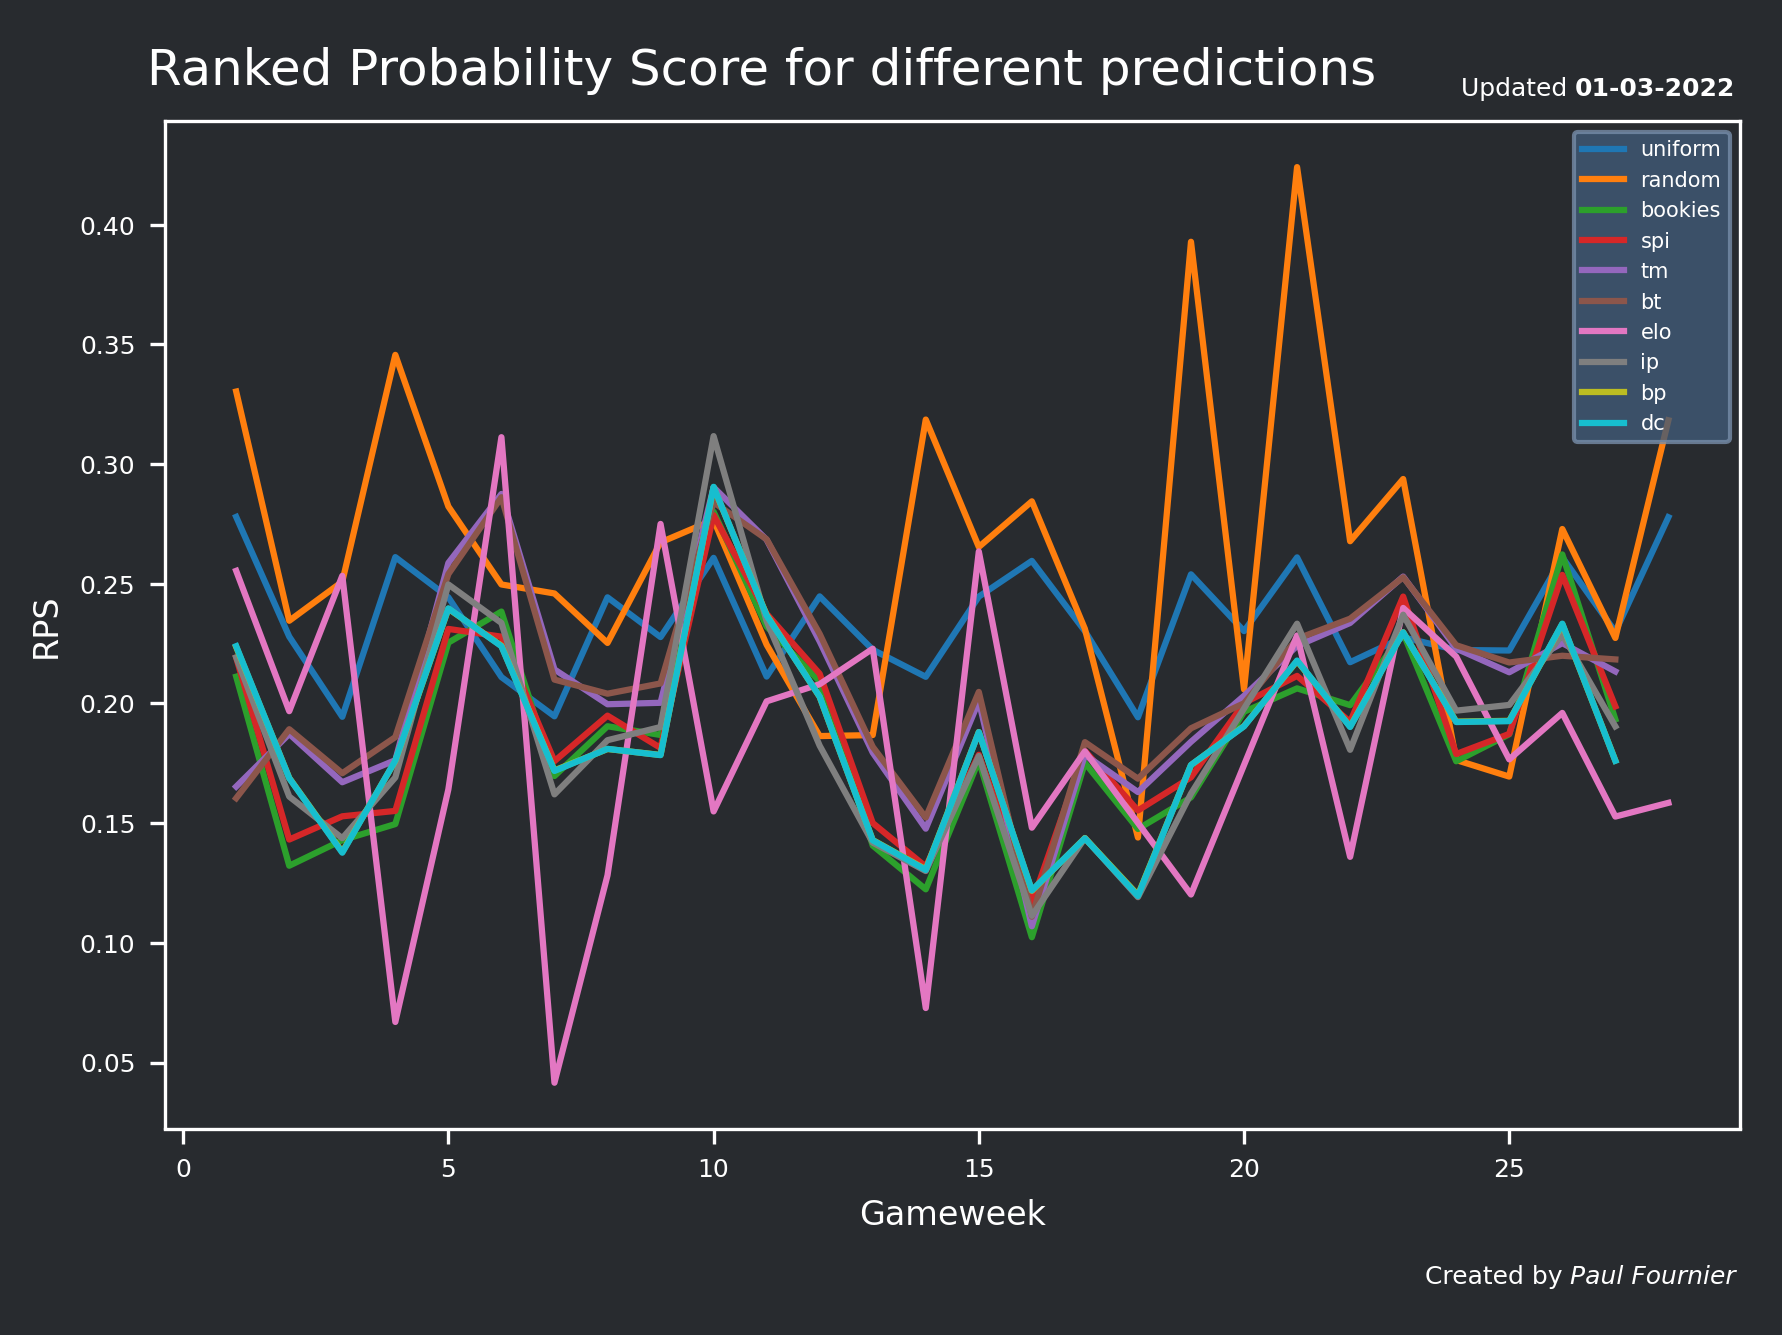

In [38]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    predictions_uniform.groupby('event').mean()['rps'],
    label='uniform',
    # color='#b7094c'
    )
ax.plot(
    predictions_random.groupby('event').mean()['rps'],
    label='random',
    # color='#b7094c'
    )
ax.plot(
    predictions_bookies.groupby('event').mean()['rps'],
    label='bookies',
    # color='#b7094c'
    )
ax.plot(
    predictions_spi.groupby('event').mean()['rps'],
    label='spi',
    # color='#b7094c'
    )
ax.plot(
    predictions_tm.groupby('event').mean()['rps'],
    label='tm',
    # color='#b7094c'
    )
ax.plot(
    predictions_bt.groupby('event').mean()['rps'],
    label='bt',
    # color='#b7094c'
    )
ax.plot(
    predictions_elo.groupby('event').mean()['rps'],
    label='elo',
    # color='#b7094c'
    )
ax.plot(
    predictions_ip.groupby('event').mean()['rps'],
    label='ip',
    # color='#b7094c'
    )
ax.plot(
    predictions_bp.groupby('event').mean()['rps'],
    label='bp',
    # color='#b7094c'
    )
ax.plot(
    predictions_dc.groupby('event').mean()['rps'],
    label='dc',
    # color='#b7094c'
    )

ax.set_xlabel('Gameweek', fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 5}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for different predictions",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.82, y=1.,
    s="Updated <01-03-2022>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.01,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()